In [1]:
!pip install easyocr opencv-python pillow matplotlib

import easyocr
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import os
import json
from typing import List, Dict, Tuple, Optional
import re
from google.colab import files
import io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 28.2 MB/s eta 0:00:00


In [9]:
class AdvancedOCRAgent:
    """
    Advanced OCR AI Agent with preprocessing, multi-language support,
    and intelligent text extraction capabilities.
    """

    def __init__(self, languages: List[str] = ['et'], gpu: bool = True):
        """Initialize OCR agent with specified languages."""
        print("🤖 Initializing Advanced OCR Agent...")
        self.languages = languages
        self.reader = easyocr.Reader(languages, gpu=gpu)
        self.confidence_threshold = 0.5
        print(f"✅ OCR Agent ready! Languages: {languages}")

    def upload_image(self) -> Optional[str]:
        """Upload image file through Colab interface."""
        print("📁 Upload your image file:")
        uploaded = files.upload()
        if uploaded:
            filename = list(uploaded.keys())[0]
            print(f"✅ Uploaded: {filename}")
            return filename
        return None

    def preprocess_image(self, image: np.ndarray, enhance: bool = True) -> np.ndarray:
        """Advanced image preprocessing for better OCR accuracy."""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        if enhance:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            gray = clahe.apply(gray)

            gray = cv2.fastNlMeansDenoising(gray)

            kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
            gray = cv2.filter2D(gray, -1, kernel)

        binary = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
        )

        return binary

    def extract_text(self, image_path: str, preprocess: bool = True) -> Dict:
        """Extract text from image with advanced processing."""
        print(f"🔍 Processing image: {image_path}")

        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")

        if preprocess:
            processed_image = self.preprocess_image(image)
        else:
            processed_image = image

        results = self.reader.readtext(processed_image)

        extracted_data = {
            'raw_results': results,
            'filtered_results': [],
            'full_text': '',
            'confidence_stats': {},
            'word_count': 0,
            'line_count': 0
        }

        high_confidence_text = []
        confidences = []

        for (bbox, text, confidence) in results:
            if confidence >= self.confidence_threshold:
                # Convert numpy arrays to lists of integers for JSON serialization
                bbox_list = [list(map(int, point)) for point in bbox]
                extracted_data['filtered_results'].append({
                    'text': text,
                    'confidence': float(confidence), # Convert confidence to float
                    'bbox': bbox_list
                })
                high_confidence_text.append(text)
                confidences.append(confidence)

        extracted_data['full_text'] = ' '.join(high_confidence_text)
        extracted_data['word_count'] = len(extracted_data['full_text'].split())
        extracted_data['line_count'] = len(high_confidence_text)

        if confidences:
            extracted_data['confidence_stats'] = {
                'mean': float(np.mean(confidences)),
                'min': float(np.min(confidences)),
                'max': float(np.max(confidences)),
                'std': float(np.std(confidences))
            }

        return extracted_data

    def visualize_results(self, image_path: str, results: Dict, show_bbox: bool = True):
        """Visualize OCR results with bounding boxes."""
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(15, 10))

        if show_bbox:
            plt.subplot(2, 2, 1)
            img_with_boxes = image_rgb.copy()

            for item in results['filtered_results']:
                # Use the list of integers from the results
                bbox = np.array(item['bbox']).astype(int)
                cv2.polylines(img_with_boxes, [bbox], True, (255, 0, 0), 2)

                x, y = bbox[0]
                cv2.putText(img_with_boxes, f"{item['confidence']:.2f}",
                           (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

            plt.imshow(img_with_boxes)
            plt.title("OCR Results with Bounding Boxes")
            plt.axis('off')

        plt.subplot(2, 2, 2)
        processed = self.preprocess_image(image)
        plt.imshow(processed, cmap='gray')
        plt.title("Preprocessed Image")
        plt.axis('off')

        plt.subplot(2, 2, 3)
        confidences = [item['confidence'] for item in results['filtered_results']]
        if confidences:
            plt.hist(confidences, bins=20, alpha=0.7, color='blue')
            plt.xlabel('Confidence Score')
            plt.ylabel('Frequency')
            plt.title('Confidence Score Distribution')
            plt.axvline(self.confidence_threshold, color='red', linestyle='--',
                       label=f'Threshold: {self.confidence_threshold}')
            plt.legend()

        plt.subplot(2, 2, 4)
        stats = results['confidence_stats']
        if stats:
            labels = ['Mean', 'Min', 'Max']
            values = [stats['mean'], stats['min'], stats['max']]
            plt.bar(labels, values, color=['green', 'red', 'blue'])
            plt.ylabel('Confidence Score')
            plt.title('Confidence Statistics')
            plt.ylim(0, 1)

        plt.tight_layout()
        plt.show()

    def smart_text_analysis(self, text: str) -> Dict:
        """Perform intelligent analysis of extracted text."""
        analysis = {
            'language_detection': 'unknown',
            'text_type': 'unknown',
            'key_info': {},
            'patterns': []
        }

        email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
        phone_pattern = r'(\+\d{1,3}[-.\s]?)?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}'
        url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
        date_pattern = r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b'

        patterns = {
            'emails': re.findall(email_pattern, text, re.IGNORECASE),
            'phones': re.findall(phone_pattern, text),
            'urls': re.findall(url_pattern, text, re.IGNORECASE),
            'dates': re.findall(date_pattern, text)
        }

        analysis['patterns'] = {k: v for k, v in patterns.items() if v}

        if any(patterns.values()):
            if patterns.get('emails') or patterns.get('phones'):
                analysis['text_type'] = 'contact_info'
            elif patterns.get('urls'):
                analysis['text_type'] = 'web_content'
            elif patterns.get('dates'):
                analysis['text_type'] = 'document_with_dates'

        if re.search(r'[а-яё]', text.lower()):
            analysis['language_detection'] = 'russian'
        elif re.search(r'[àáâãäåæçèéêëìíîïñòóôõöøùúûüý]', text.lower()):
            analysis['language_detection'] = 'romance_language'
        elif re.search(r'[一-龯]', text):
            analysis['language_detection'] = 'chinese'
        elif re.search(r'[ひらがなカタカナ]', text):
            analysis['language_detection'] = 'japanese'
        elif re.search(r'[a-zA-Z]', text):
            analysis['language_detection'] = 'latin_based'

        return analysis

    def process_batch(self, image_folder: str) -> List[Dict]:
        """Process multiple images in batch."""
        results = []
        supported_formats = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')

        for filename in os.listdir(image_folder):
            if filename.lower().endswith(supported_formats):
                image_path = os.path.join(image_folder, filename)
                try:
                    result = self.extract_text(image_path)
                    result['filename'] = filename
                    results.append(result)
                    print(f"✅ Processed: {filename}")
                except Exception as e:
                    print(f"❌ Error processing {filename}: {str(e)}")

        return results

    def export_results(self, results: Dict, format: str = 'json') -> str:
        """Export results in specified format."""
        if format.lower() == 'json':
            # Ensure all numerical values are standard Python types for JSON serialization
            def convert_to_serializable(obj):
                if isinstance(obj, np.integer):
                    return int(obj)
                elif isinstance(obj, np.floating):
                    return float(obj)
                elif isinstance(obj, np.ndarray):
                    return obj.tolist()
                elif isinstance(obj, dict):
                    return {k: convert_to_serializable(v) for k, v in obj.items()}
                elif isinstance(obj, (list, tuple)): # Updated to handle tuples
                    return [convert_to_serializable(item) for item in obj]
                else:
                    return obj

            serializable_results = convert_to_serializable(results)
            output = json.dumps(serializable_results, indent=2, ensure_ascii=False)
            filename = 'ocr_results.json'
        elif format.lower() == 'txt':
            output = results['full_text']
            filename = 'extracted_text.txt'
        else:
            raise ValueError("Supported formats: 'json', 'txt'")

        with open(filename, 'w', encoding='utf-8') as f:
            f.write(output)

        print(f"📄 Results exported to: {filename}")
        return filename

🚀 Advanced OCR AI Agent Demo
🤖 Initializing Advanced OCR Agent...
✅ OCR Agent ready! Languages: ['et']
📁 Upload your image file:


Saving ocr_testi.png to ocr_testi (1).png
✅ Uploaded: ocr_testi (1).png
🔍 Processing image: ocr_testi (1).png

📊 OCR Results:
Words detected: 9
Lines detected: 6
Average confidence: 0.66

📝 Extracted Text:
------------------------------
Sähkäpostíosoite: kanssasi sähköisesti? Onkq Onko:jäkin Palkka tai palkko uvan,
------------------------------

🧠 Smart Analysis:
Detected text type: unknown
Language hints: romance_language


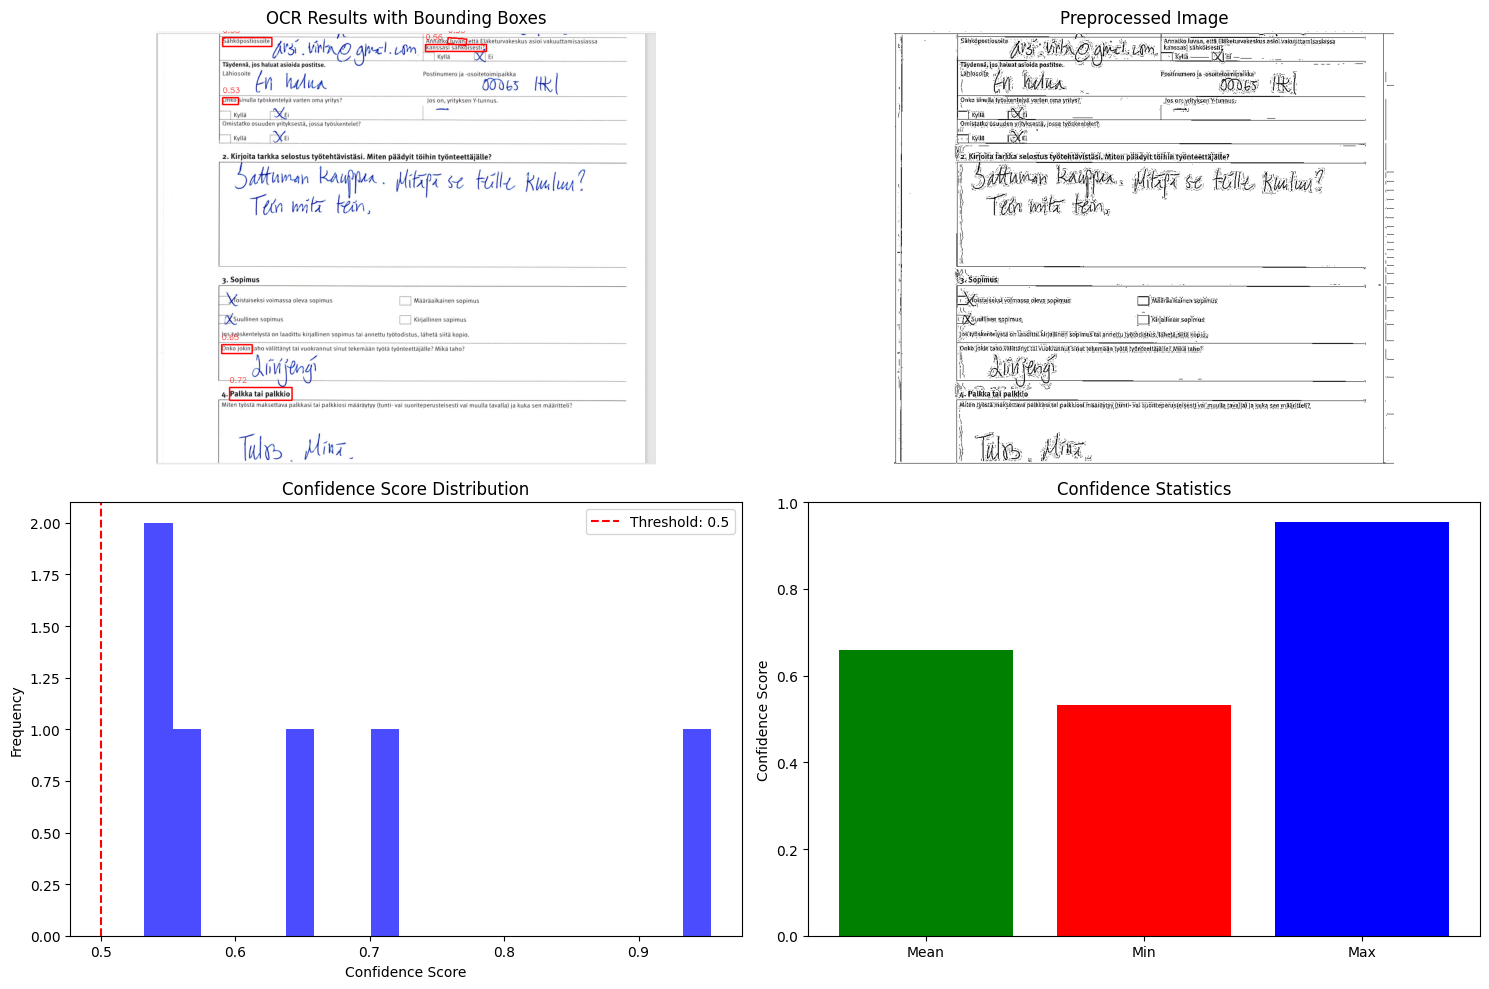

❌ Error: Object of type int32 is not JSON serializable


In [6]:
def demo_ocr_agent():
    """Demonstrate the OCR agent capabilities."""
    print("🚀 Advanced OCR AI Agent Demo")
    print("=" * 50)

    ocr = AdvancedOCRAgent(languages=['et'], gpu=True)

    image_path = ocr.upload_image()
    if image_path:
        try:
            results = ocr.extract_text(image_path, preprocess=True)

            print("\n📊 OCR Results:")
            print(f"Words detected: {results['word_count']}")
            print(f"Lines detected: {results['line_count']}")
            print(f"Average confidence: {results['confidence_stats'].get('mean', 0):.2f}")

            print("\n📝 Extracted Text:")
            print("-" * 30)
            print(results['full_text'])
            print("-" * 30)

            analysis = ocr.smart_text_analysis(results['full_text'])
            print(f"\n🧠 Smart Analysis:")
            print(f"Detected text type: {analysis['text_type']}")
            print(f"Language hints: {analysis['language_detection']}")
            if analysis['patterns']:
                print(f"Found patterns: {list(analysis['patterns'].keys())}")

            ocr.visualize_results(image_path, results)

            ocr.export_results(results, 'json')

        except Exception as e:
            print(f"❌ Error: {str(e)}")
    else:
        print("No image uploaded. Please try again.")

if __name__ == "__main__":
    demo_ocr_agent()

🚀 Advanced OCR AI Agent Demo
🤖 Initializing Advanced OCR Agent...
✅ OCR Agent ready! Languages: ['et']
📁 Upload your image file:


Saving ocr_testi.png to ocr_testi (2).png
✅ Uploaded: ocr_testi (2).png
🔍 Processing image: ocr_testi (2).png

📊 OCR Results:
Words detected: 9
Lines detected: 6
Average confidence: 0.66

📝 Extracted Text:
------------------------------
Sähkäpostíosoite: kanssasi sähköisesti? Onkq Onko:jäkin Palkka tai palkko uvan,
------------------------------

🧠 Smart Analysis:
Detected text type: unknown
Language hints: romance_language


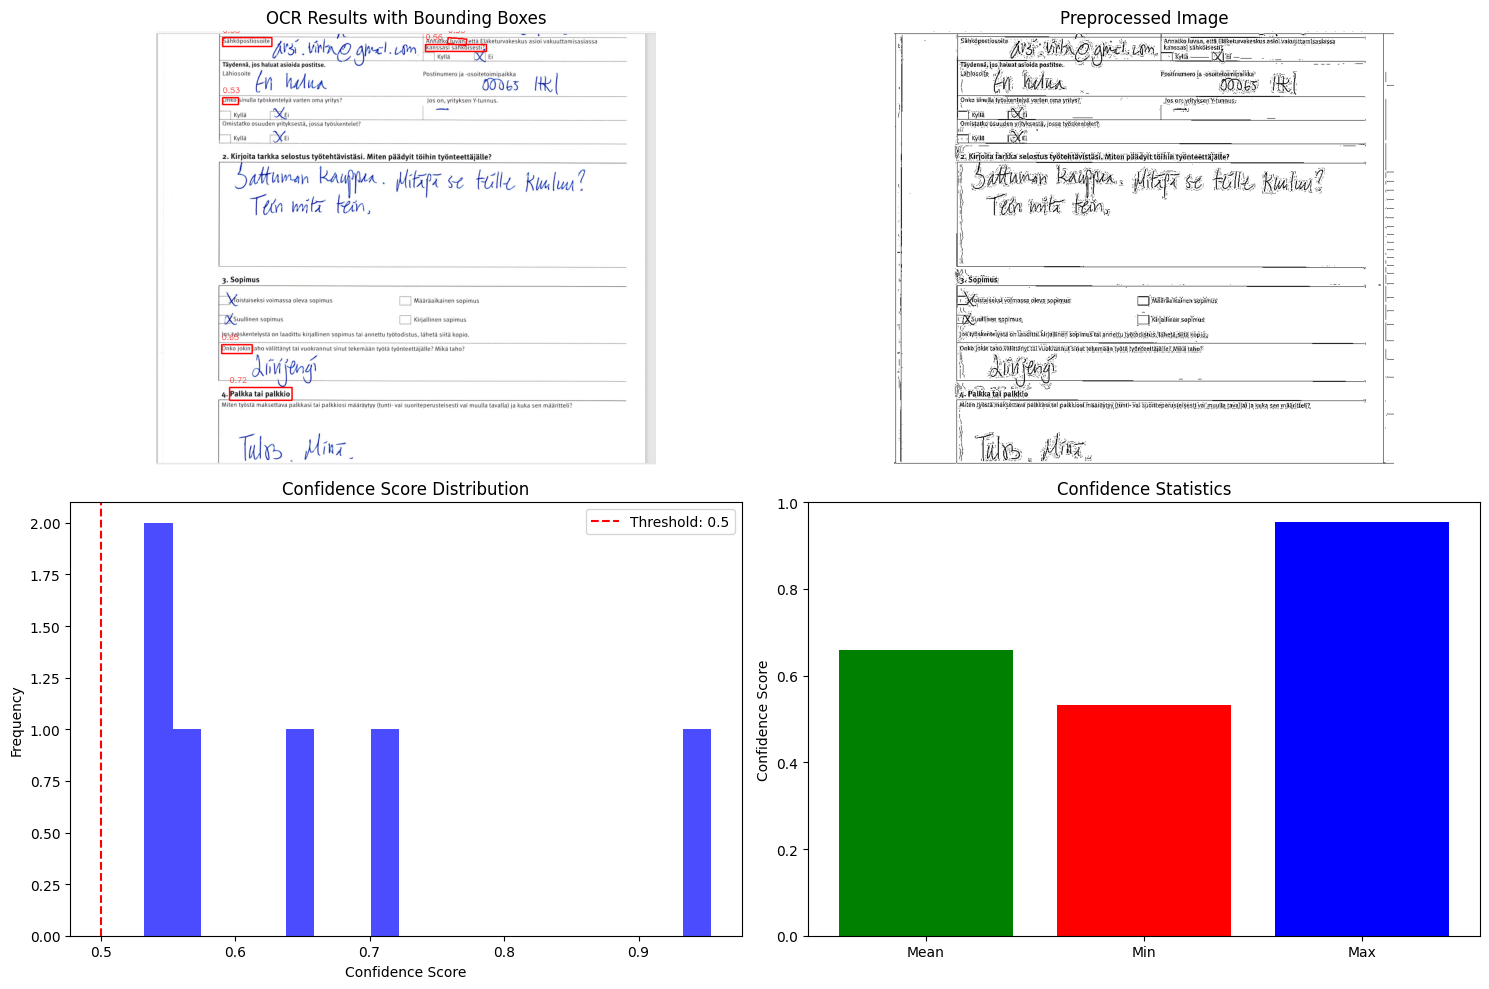

❌ Error: Object of type int32 is not JSON serializable


In [8]:
demo_ocr_agent()

In [ ]:
demo_ocr_agent()